In [1]:
# plot the percentage barplot
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

#start here to run analysis
def read_common_edges(cate):
    all_df= pd.read_csv(f"{cate}_common_edges.txt",index_col=None)
    all_df["A"] = all_df["A"] +"_"+all_df["B"]
    all_df.drop(columns=["B"],inplace=True)
    df_cl = pd.read_csv("../braun_data_log2_or_not/braun_data_S1_Clinical_and_Immune_Data.csv")
    df_os = pd.merge(all_df.set_index("A").T.reset_index(),df_cl,how='left', left_on="index", right_on="RNA_ID")
    return df_os

cate = "metaEver"  # ["primaryNivo","primaryEver","metaNivo","metaEver"]:

df_os_merge =read_common_edges(cate)
df_os_merge.rename(columns={"index": "A_B"},inplace=True)

10


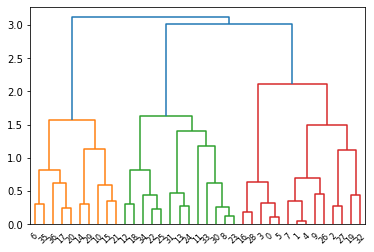

In [4]:
df_cox_os = pd.read_csv(f"./cox_result/cox_result_{cate}_os.txt",index_col=0)
df_cox_pfs = pd.read_csv(f"./cox_result/cox_result_{cate}_pfs.txt",index_col=0)

#edges_cox = set(df_cox_pfs[df_cox_pfs["p"]<0.05].index.tolist()).union(df_cox_os[df_cox_os["p"]<0.05].index.tolist())
edges_inter = set(df_cox_pfs[df_cox_pfs["p"]<0.01].index.tolist()).intersection(df_cox_os[df_cox_os["p"]<0.01].index.tolist())
#edges_inter = df_cox_pfs[df_cox_pfs["p"]<0.001].index.tolist()
#edges_inter = df_cox_os[df_cox_os["p"]<0.001].index.tolist()
print(len(edges_inter))


df_sns = df_os_merge.copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[list(edges_inter)]

colors = df_os_merge.copy().sort_values(by="Benefit")["Benefit"].replace("ICB","yellow").replace("NCB","red").replace("CB","green").tolist()

df_sns = df_sns.astype("float64")

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy import stats

linkage_data = linkage(pdist(stats.zscore(df_sns), 'cosine'), method='ward', metric='euclidean')
dn = dendrogram(linkage_data)
from scipy.cluster.hierarchy import fcluster

fl = fcluster(linkage_data,3,criterion='maxclust')
pdf = df_os_merge.copy().sort_values(by="Benefit").set_index("A_B").copy()

def swapPositions(lis):
    newlis = []
    for i in lis:
        if i == 1:
            newlis.append(2)
        if i == 2:
            newlis.append(1)
    return newlis

fl[fl == 1] = 2
fl[fl == 3] = 1
pdf["cres"] =fl
#pdf["cres"] =swapPositions(fl)

1 14
2 23


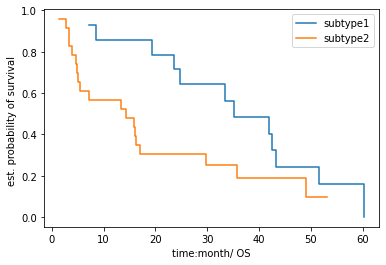

In [5]:
for i in set(fl):
    print(i,list(fl).count(i))

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

pdf["OS_CNSR"] = pdf["OS_CNSR"]==1

for i in set(fl):
    speci_df = pdf[pdf["cres"]==i]
    time, survival_prob, conf_int = kaplan_meier_estimator(
        speci_df["OS_CNSR"], \
        speci_df["OS"], conf_type="log-log"
)
    plt.step(time, survival_prob, where="post", label=f"subtype{i}")
    #plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylabel("est. probability of survival ")
plt.xlabel("time:month/ OS")
plt.legend(loc="best") 

In [6]:
from scipy.stats import ranksums
y1,y2,y3= [] ,[],[]
for i in ['Purity','Ploidy','TM_CD8_Density','TC_CD8_Density',
          'TM_TC_Ratio','TM_CD8_PERCENT','TC_CD8_PERCENT',
          'TMB_Counts','FS_Counts','NEO_Weak','WGII','ITH']:
    c1,c2= pdf[pdf["cres"]==1][i],pdf[pdf["cres"]==2][i]
    y1.append(c1.mean())
    y2.append(c2.mean())
    result = ranksums(c1,c2,nan_policy="omit",alternative="greater")
    y3.append(result.pvalue)
    print(i,result)

Purity RanksumsResult(statistic=-0.2114722130550724, pvalue=0.5837405936603622)
Ploidy RanksumsResult(statistic=0.0, pvalue=0.5)
TM_CD8_Density RanksumsResult(statistic=-1.1547005383792517, pvalue=0.8758934605050381)
TC_CD8_Density RanksumsResult(statistic=-0.2886751345948129, pvalue=0.6135850036577762)
TM_TC_Ratio RanksumsResult(statistic=-2.3094010767585034, pvalue=0.989539332331103)
TM_CD8_PERCENT RanksumsResult(statistic=-1.1547005383792517, pvalue=0.8758934605050381)
TC_CD8_PERCENT RanksumsResult(statistic=-0.2886751345948129, pvalue=0.6135850036577762)
TMB_Counts RanksumsResult(statistic=-0.3333333333333333, pvalue=0.6305586598182363)
FS_Counts RanksumsResult(statistic=-0.16666666666666666, pvalue=0.5661838326109037)
NEO_Weak RanksumsResult(statistic=-0.7222222222222222, pvalue=0.7649210685711652)
WGII RanksumsResult(statistic=-0.4581897949526569, pvalue=0.6765919545271326)
ITH RanksumsResult(statistic=0.1057361065275362, pvalue=0.45789586602529475)


from scipy.stats import ranksums
y1,y2,y3,y4= [] ,[],[],[]
for i in ['Purity','Ploidy','TM_CD8_Density','TC_CD8_Density',
          'TM_TC_Ratio','TM_CD8_PERCENT','TC_CD8_PERCENT',
          'TMB_Counts','FS_Counts','NEO_Weak','WGII','ITH']:
    c1,c2,c3,c4= pdf[pdf["cres"]==1][i],pdf[pdf["cres"]==2][i],pdf[pdf["cres"]==3][i],pdf[pdf["cres"]==4][i]
    y1.append(c1.mean())
    y2.append(c2.mean())
    y3.append(c3.mean())
    y4.append(c4.mean())
    result = ranksums(c1,c2,nan_policy="omit",alternative="greater")
    print(i,result)

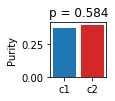

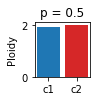

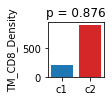

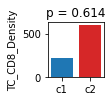

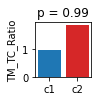

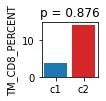

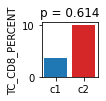

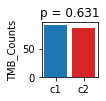

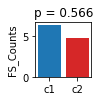

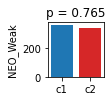

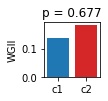

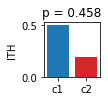

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 
  
# plot data in grouped manner of bar type 
for  i,j in enumerate(['Purity','Ploidy','TM_CD8_Density','TC_CD8_Density',
          'TM_TC_Ratio','TM_CD8_PERCENT','TC_CD8_PERCENT',
          'TMB_Counts','FS_Counts','NEO_Weak','WGII','ITH']):          

    fig, ax = plt.subplots(figsize=(1, 1))
    counts = [y1[i],y2[i]]
    fruits = ['c1', 'c2']
    bar_colors = ['tab:blue', 'tab:red']    
    ax.bar(fruits, counts, color=bar_colors)
    ax.set_ylabel(j)
    ax.set_title('p = {:.3}'.format(y3[i]))
    plt.savefig(f"f4.{cate}_{j}.tif",dpi=600,bbox_inches='tight')
    plt.savefig(f"f4.{cate}_{j}.svg",dpi=600,bbox_inches='tight')
    plt.show()
    plt.close()


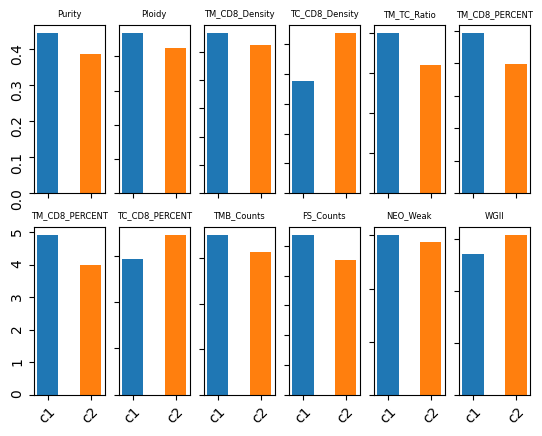

In [42]:
fig, axs = plt.subplots(2, 6)

width = 0.4
for j in range(0,6):
    x = j
    i = 0
    axs[i, j].bar(1-width, y1[j], width) 
    axs[i, j].bar(1+width, y2[j], width) 
    axs[i, j].set_title(f"{labels[j]}", fontsize=6)
    #axs[i, j].set_xticks([x-width,x+width],labels=["c1","c2"],rotation=45)
    #axs[i, j].xticks([x-0.2,x+0.2], ["c1","c2"],rotation=45) 
    axs[i, j].set_xticks([1-width,1+width], ["c1","c2"],rotation=45) 
    axs[i, j].yaxis.set_tick_params(rotation=90)
    
for j in range(0,6):
    x = j +5
    i = 1
    axs[i, j].bar(1-width, y1[x], width) 
    axs[i, j].bar(1+width, y2[x], width) 
    axs[i, j].set_title(f"{labels[x]}", fontsize=6)
    axs[i, j].set_xticks([1-width,1+width], ["c1","c2"],rotation=45) 
    axs[i, j].yaxis.set_tick_params(rotation=90)
    
for ax in axs.flat:
    ax.label_outer()

<Axes: >

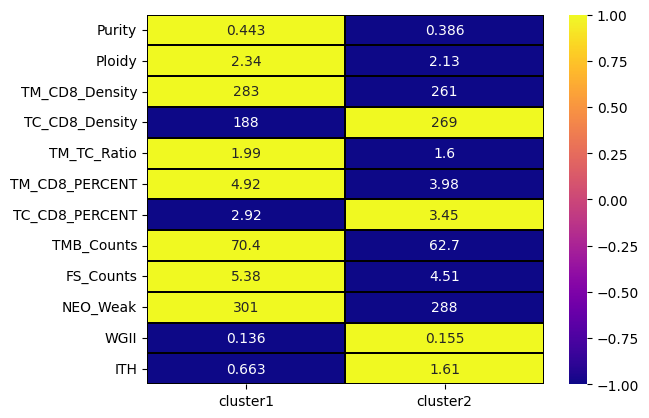

In [9]:
# heatmap 
from scipy import stats
df = pd.DataFrame.from_dict({"cluster1":y1,"cluster2":y2})#,"cluster3":y3,"cluster4":y4})
df.index = labels
sns.heatmap(stats.zscore(df,axis=1),annot = df,
            fmt = '.3g', linecolor="black",linewidth=.15,
            cmap="plasma",cbar_ax=None)


In [44]:
y3

[0.06239701256204438,
 0.17878070906634408,
 0.33303210757904367,
 0.6883153685405132,
 0.1228745240645508,
 0.23029830935238566,
 0.6240851829770754,
 0.22693130124246774,
 0.14576020387902167,
 0.45062074464580093,
 0.6729571303539568,
 0.8727112857380934]